# Bundle Adjustment

Part of this assignment is based on scipy-cookbook. It will take around 2 hours to finish.

# Question 1: Reading

1. Read the paper 'Building Rome in a Day' and briefly write about the fundamental idea behind the problem and solution. No need to be verbose, just write about the challenge with the task and how the pipeline is implemented (do not include details about performance/parallelization).

2. How is this task different from a SLAM problem?

# Question 2: Code!

### Task
We have a set of points in real world defined by their coordinates $(X, Y, Z)$ in some apriori chosen "world coordinate frame". We photograph these points by different cameras, which are characterized by their orientation and translation relative to the world coordinate frame and also by focal length and two radial distortion parameters (9 parameters in total). Then we precicely measure 2-D coordinates $(x, y)$ of the points projected by the cameras on images. Our task is to refine 3-D coordinates of original points as well as camera parameters, by minimizing the sum of squares of reprojecting errors.

We will be using a dataset from http://grail.cs.washington.edu/projects/bal/ for this task. Feel free to choose any of the ones mentioned on the page. Take the smallest file from each dataset (you can choose any but it will take longer to run, consume more memory)

In [2]:
import urllib
import copy
import bz2
import os
import numpy as np
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


First download the data file:

In [2]:
BASE_URL = "http://grail.cs.washington.edu/projects/bal/data/"

DATASET_NAME = "final/"
FILE_NAME = "problem-13682-4456117-pre.txt.bz2"

URL = BASE_URL + DATASET_NAME + FILE_NAME

In [3]:
if not os.path.isfile(FILE_NAME):
    urllib.request.urlretrieve(URL, FILE_NAME)

Now read the data from the file:

In [4]:
def read_bal_data(file_name):
    with bz2.open(file_name, "rt") as file:
        n_cameras, n_points, n_observations = map(
            int, file.readline().split())

        camera_indices = np.empty(n_observations, dtype=int)
        point_indices = np.empty(n_observations, dtype=int)
        points_2d = np.empty((n_observations, 2))

        for i in range(n_observations):
            camera_index, point_index, x, y = file.readline().split()
            camera_indices[i] = int(camera_index)
            point_indices[i] = int(point_index)
            points_2d[i] = [float(x), float(y)]

        camera_params = np.empty(n_cameras * 9)
        for i in range(n_cameras * 9):
            camera_params[i] = float(file.readline())
        camera_params = camera_params.reshape((n_cameras, -1))

        points_3d = np.empty(n_points * 3)
        for i in range(n_points * 3):
            points_3d[i] = float(file.readline())
        points_3d = points_3d.reshape((n_points, -1))

    return camera_params, points_3d, camera_indices, point_indices, points_2d

In [5]:
camera_params, points_3d, camera_indices, point_indices, points_2d = read_bal_data(FILE_NAME)

In [6]:
print(f"camera_params: {camera_params.shape};\npoints_3d: {points_3d.shape};\n"
        f"camera_indices: {camera_indices.shape}; \npoint_indices: {point_indices.shape}; \n"
        f"points_2d: {points_2d.shape}")

camera_params: (13682, 9);
points_3d: (4456117, 3);
camera_indices: (28987644,); 
point_indices: (28987644,); 
points_2d: (28987644, 2)


Here we have numpy arrays:

1. `camera_params` with shape `(n_cameras, 9)` contains initial estimates of parameters for all cameras. First 3 components in each row form a **rotation vector**, next 3 components form a translation vector, then a focal distance and two distortion parameters.
2. `points_3d` with shape `(n_points, 3)` contains initial estimates of point coordinates in the world frame.
3. `points_2d` with shape `(n_observations, 2)` contains measured 2-D coordinates of points projected on images in all the observations.
4. `camera_ind` with shape `(n_observations,)` gives the index of the camera (from 0 to `n_cameras - 1`) associated with a particular observation.   
5. `point_ind` with shape `(n_observations,)` contains indices of 3D points (from 0 to `n_points - 1`) involved in each observation.

# Visualise Point Cloud

Visualise `points_3d`. It may not look like 'Venice' or any building as we are working with a small subset.

In [7]:
# # Mostly useless
# pcd = o3d.geometry.PointCloud()
# pcd.points = o3d.utility.Vector3dVector(points_3d)
# o3d.visualization.draw_geometries([pcd])

# Extract Parameters

How many cameras and 3D points do we have? Calculate the number of parameters to estimate.

In [8]:
n_cameras = camera_params.shape[0]
n_points = points_3d.shape[0]
m = 2 * points_2d.shape[0]
n = 9 * n_cameras + 3 * n_points

print("n_cameras: {}".format(n_cameras))
print("n_points: {}".format(n_points))
print("Total number of parameters to estimate: {}".format(n))
print("Total number of residuals: {}".format(m))

n_cameras: 13682
n_points: 4456117
Total number of parameters to estimate: 13491489
Total number of residuals: 57975288


We chose a relatively small problem to reduce computation time, but scipy's algorithm is capable of solving much larger problems, although required time will grow proportionally.

Now define the function which returns a vector of residuals. We use numpy vectorized computations:

### A short review on Transformations

Rodrigues Formula: $$\mathbf{R}=\cos \theta \mathbf{I}+(1-\cos \theta) \mathbf{n n}^{\mathrm{T}}+\sin \theta \mathbf{n}^{\wedge}$$
If described by a rotation vector, assuming that the rotation axis is a unit length vector $\mathbf{n}$ and the angle is $\theta$, then the vector $\theta \mathbf{n}$ can also describe this rotation. Here, rot_vecs = $\theta \mathbf{n}$.

In [9]:
def rotate(points, rot_vecs):
    """Rotate points by given rotation vectors.
    
    Rodrigues' rotation formula is used.
    """
    theta = np.linalg.norm(rot_vecs, axis=1)[:, np.newaxis] #np.newaxis converts this into a column vector.
    with np.errstate(invalid='ignore'):
        v = rot_vecs / theta
        v = np.nan_to_num(v)
    dot = np.sum(points * v, axis=1)[:, np.newaxis]
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    
    return (cos_theta * points) + ((1 - cos_theta) * v * dot) + (sin_theta * np.cross(v, points))

## A short review on camera modelling & radial distortion



- Each pixel moves radially away from (barrel) or towards (pincushion) the image center (c).
- As a function of distance from $c: r_{c}^{2}=x_{c}^{2}+y_{c}^{2}$.
- The shift $\gamma$ can be modelled as: $\gamma=1+k_{1} r_{c}^{2}+k_{2} r_{c}^{4}$ where ${k}_{1}$ and ${k}_{2}$ are radial distortion parameters.
- The modified co-ordinates are:

$$\begin{array}{l}
\hat{x}_{c}=\gamma x_{c} \\
\hat{y}_{c}=\gamma y_{c}
\end{array} 
$$

- **This is applied before the focal-length multiplier and center shift are applied**: Meaning before $K$ matrix is even applied. But how do we exactly do that?

    $$\mathbf{K}=\left[\begin{array}{ccc}\alpha_{x} & 0 & x_{0} \\0 & \alpha_{y} & y_{0} \\0 & 0 & 1\end{array}\right] ; \qquad      \lambda {p} = \mathrm{x} =K[R \quad t] \mathrm{X}$$

    $$x_{final} = \gamma \left(\frac{f_0X}{Z}+c_x \right)
     \qquad \color{red} \bigotimes \textbf{wrong}$$

    $$x_{final} =  \left(f_0 \left(\gamma\frac{X}{Z} \right)+c_x \right)
     \qquad \color{surd} \checkmark \textbf{correct}$$

### Summing it up
Let $\pmb{P} = (X, Y, Z)^T$ - a radius-vector of a point, $\pmb{R}$ - a rotation matrix of a camera, $\pmb{t}$ - a translation vector of a camera, $f$ - its focal distance, $k_1, k_2$ - its distortion parameters. Then the reprojecting is done as follows:

\begin{align}
\pmb{Q} = \pmb{R} \pmb{P} + \pmb{t} \\
\pmb{q} = -\begin{pmatrix} Q_x / Q_z \\ Q_y / Q_z \end{pmatrix} \\
\pmb{p} = f (1 + k_1 \lVert \pmb{q} \rVert^2 + k_2 \lVert \pmb{q} \rVert^4) \pmb{q}
\end{align}
The resulting vector $\pmb{p}=(x, y)^T$ contains image coordinates of the original point.
![radial_distortion_1.png](../misc/radial_distortion_1.png) 
![radial_distortion_2.png](../misc/radial_distortion_2.png)

In [10]:
def project(points, camera_params):
    """Convert 3-D points to 2-D by projecting onto images."""
    
    projpoi = rotate(points, camera_params[:, :3])
    projpoi = projpoi + camera_params[:, 3:6]
    projpoi = -1*projpoi[:, :2] / projpoi[:, 2, np.newaxis]
    n = np.sum(projpoi**2, axis=1)
    r = 1 + camera_params[:, 7] * n + camera_params[:, 8] * n**2
    projpoi = projpoi * (r * camera_params[:, 6])[:, np.newaxis]
    return projpoi

In [11]:
def fun(params, n_cameras, n_points, camera_indices, point_indices, points_2d):
    """Compute residuals.
    
    `params` contains camera parameters and 3-D coordinates.
    """
    params = copy.deepcopy(params)
    camera_params = params[:n_cameras * 9].reshape((n_cameras, 9))
    
    points_3d = params[n_cameras * 9:].reshape((n_points, 3))
    points_proj = project(points_3d[point_indices], camera_params[camera_indices])
    return (points_proj - points_2d).ravel()

## A short review on Structure from Motion
### Residual
In our lecture, in the residual vector, we  wrote the elements in order: 11, 12, 13.., 1N, then 21, 22.. and so on till MN. However, notice that it is not the case here.

M -> camera, N -> 3D point (in our lectures, NOT in this code)
![sfm_residual_1.png](./misc/sfm_residual_1.png)

You can see that computing Jacobian of `fun` is cumbersome, thus we will rely on the finite difference approximation. To make this process time feasible we provide Jacobian sparsity structure (i. e. mark elements which are known to be non-zero):

![sfm_jac_2.png](./misc/sfm_jac_2.png)

Since the matrix is sparse, we can make use of datastructures that are meant for such a usecase - https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.lil_matrix.html.

In [7]:
from scipy.sparse import lil_matrix

The code for the matrix computation has been given to you, you will have to explain this function later on.

In [8]:
def bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices):
    m = camera_indices.size * 2 
    n = n_cameras * 9 + n_points * 3
            
    A = lil_matrix((m, n), dtype=int)

    camera_indices = np.sort(camera_indices)
    point_indices = np.sort(point_indices)
    
    i = np.arange(camera_indices.size)
    for s in range(9):
        A[2 * i, camera_indices * 9 + s] = 1
        A[2 * i + 1, camera_indices * 9 + s] = 1

    for s in range(3):
        A[2 * i, n_cameras * 9 + point_indices * 3 + s] = 1
        A[2 * i + 1, n_cameras * 9 + point_indices * 3 + s] = 1
            
    return A

### THAT'S IT! Now we are ready to use inbuilt library functions!
Now we are ready to run optimization. Let's visualize residuals evaluated with the initial parameters.

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

In [15]:
x0 = np.hstack((camera_params.ravel(), points_3d.ravel()))

In [16]:
f0 = fun(x0, n_cameras, n_points, camera_indices, point_indices, points_2d)

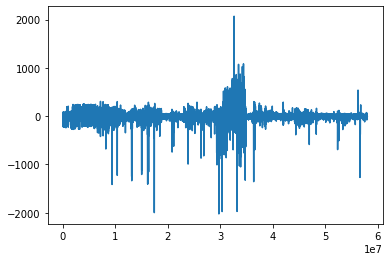

In [17]:
plt.plot(f0)

In [ ]:
A = bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices)
print(A.shape, n_cameras, n_points)

### Optimization

Scipy has existing functions for optimization that we can make use of. Write a sentence about the method that is used for optimization

In [ ]:
import time
from scipy.optimize import least_squares

In [ ]:
t0 = time.time()
# So far: method='lm'
res = least_squares(fun, x0, jac_sparsity=A, verbose=2, x_scale='jac', ftol=1e-4, method='trf',
                    args=(n_cameras, n_points, camera_indices, point_indices, points_2d))
t1 = time.time()

In [ ]:
params = res.x

new_camera_params = params[:n_cameras * 9].reshape((n_cameras, 9))
new_points_3d = params[n_cameras * 9:].reshape((n_points, 3))

### Plot Optimised Points

In [ ]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(new_points_3d)
o3d.visualization.draw_geometries([pcd])

Setting `scaling='jac'` was done to automatically scale the variables and equalize their influence on the cost function (clearly the camera parameters and coordinates of the points are very different entities). This option turned out to be crucial for successfull bundle adjustment.

In [ ]:
print("Optimization took {0:.0f} seconds".format(t1 - t0))

Now let's plot residuals at the found solution:

In [ ]:
plt.plot(res.fun)

We see much better picture of residuals now, with the mean being very close to zero. There are some spikes left. It can be explained by outliers in the data, or, possibly, the algorithm found a local minimum (very good one though) or didn't converged enough. Note that the algorithm worked with Jacobian finite difference aproximate, which can potentially block the progress near the minimum because of insufficient accuracy (but again, computing exact Jacobian for this problem is quite difficult).

### Project 2- Part B: Submission details -
You are supposed to gain understanding by playing around with the code above and submit your answers to questions asked below. You shouldn't submit this whole notebook, just copy the following cells (starting next cell up until the end of this notebook) and paste it at the end of your Project 2 notebook (already shared on GitHub classrooms, [link](https://github.com/AryanSakaria/Project_2/blob/main/Project_2.ipynb)).

# Theory

## 1. SfM pipeline (`6 mark`)

To get the context of below questions, take a look at the code above: The same questions have been asked at different places above as comments in the code.

1. `0.5 mark` **Basics** - How do we know this (`camera_ind`) information in practical setting? In other words, how do we know observations in `points_2d` belong to which camera. Explain. 
    - Ans-1 - Basics: Bundle Adjustment is the backend for SfM (structure from motion). We have algorithms like SIFT or ORB on the frontend side to find corresponding points in two images. After this we can use 8 point algorithm to get the Fundamental Matrix. Knowing the camera intrinsics we can get the Essential Matrix and we decompose it to get R,t and K. After this we triangulate back the points from those two images into the 3D world . Here will we know which image the points being backprojected came from (due to camera_ind). PnP can be used on correspondences between the reconstructed world and the third image to get the transformation to adjust to same scale. We will keep repeating this for all images. Thus, we know which of the points_2d belong to which camera because those points are chosen after running SIFT/ORB or other feature detection algorithms on the image from that camera.
    
    
2. `0.5 mark` **Basics** - How do we know this (`point_ind`) information in practical setting?  In other words, how do we know observations in `points_2d` belong to which 3D point. Explain.
    - Ans-2 - Basics: We know that images in different views are taken at different poses. Using this we have SIFT/SURF or ORB to find corresponding points between two images. After this we can use 8 point algorithm to estimate the Fundamental Matrix from which we can get the Essential Matrix and decompose them into R,t and K. Further we can triangulate or backproject points to the world to obtain 3D points. Because of this, we now get our 2D-3D correspondences.
    
    
3. `0.5 mark` **Transformations** - `rotate()` function: Why do we use the rodriquez formula? How is this representation different from the standard 3x3 Rotation matrix, why do we use this instead?
    - Ans-3 - Transformations: We use rodriguez formula as this reduces the number of unknows. P has 12 unknowns (11 if normalized). R has 6 unknows and if we use rodrigues formula then the number of unknowns coming from rotation drop to 3. Hence the number of overalls in the P matrix come down to 9 which means lesser points are needed. This representation is different as here we represent our rotation about the vector k, a unit vector describing an axis of rotation about which our vector rotates by an angle θ. Formula:
    ![Rodrigues Formula](https://wikimedia.org/api/rest_v1/media/math/render/svg/2d63efa533bdbd776434af1a7af3cdafaff1d578)
    
    
4. `0.5 mark` **Transformations** - `project()` function: In the `project()` function, would it make any difference if I do translate first, then rotate? Why/why not?
    - Ans-4 - Transformations: Yes, there may be a difference if we translate first and then rotate. Translation before rotation implies that we're moving to a different origin first and rotating about that origin. Hence the transformation matrix will change. Translating after rotating is moving the rotation center. If the translation vector itself lies in the camera frame itself, it is necessary that the point be first rotated to the camera frame before it may be added to the translation vector. Or else the translation vector and the point would lie in some other frame.
        
        
5. `0.5 mark` **Jacobian** - `bundle_adjustment_sparsity()` function: m above is not "M*N" (*2) unlike our lecture notes. Why is that so?
    - Ans-5 - Jacobian: Each row of the Jacobian corresponds to a residual, so number of rows is equal to number of rows in residuals.  If we have M images and N points in each image, we have MN 2D points, each giving 2 coordinates, so 2MN residuals for rows of the Jacobian. Here, since m contains the info about all the observations made together (all 2D points), i.e., camera_indices.size 2D points we have a different size for it.
    
    
6. `2 mark` **Jacobian & Parameters** - `bundle_adjustment_sparsity()` function: 
    1.  Why are we doing `n_cameras * 9` here instead of `n_cameras * 12`? Recollect: Every individual motion Jacobian was (1*)12 in our lecture notes. 
        - Ans 6.1 - Jacobian & Parameters: In our stereo code, projection matrix is dependent on 12 parameters (size = 3x4). However in the bundle adjustment code instead of having to use the elements of the projection matrix, we are using 3 translational parameters, 3 rotational parameters represented in axis-angle form, and 3 parameters for camera intrinsics, namely the focal length and 2 distortion parameters. So our P has 9 parameters, and hence we are using n_cameras * 9.
        
    2. Ignoring the scale parameters, what was the number of unknown parameters in our lecture notes in terms of `n_cameras` and `n_points`? What is it here in the code? Is it different? If so, what is and why? [Link of notes](https://www.notion.so/Stereo-Structure-from-Motion-9fdd81e4194f4803ac9ba7552df56470).
        - Ans 6.2 - Jacobian & Parameters: In our lecture notes, P had 12 unknowns/parameters but here it has 9 parameters. So in our lectures, number of unknown params was (n_cameras * 12  + n_points * 3), where n_points = (n_images x n_points_per_image)/n_times_every_point_is_seen). In the current implementation though, we are already given n_cameras and n_points, and the number of parameters required is also 9, so the total number of unknowns comes to (n_cameras * 9 + n_points * 3)
       
            
            
7. `6 mark` **Sparsity, Residual Vector & Jacobian** - `bundle_adjustment_sparsity()` function: Explain what you understand from above 6 lines of code by coding a simple toy example yourself to illustrate how it is different from what you've learnt in class. ([Coding toy example + elaborating in words]- both are compulsory.) For the toy example, you can take something like 3 points all seen from 3 cameras. (You don't actually have to code much, just need to call the existing function) Write that toy example after this cell
    - Ans 6 - Sparsity, Residual Vector & Jacobian: The jacobian is computed w.r.t the 9 parameters of P and 3 for each point. Each of these will correspond to one column of the Jacobian. So as we have n_cameras, there will be `n_cameras*9` columns due to P followed by, for n_points, there are `n_points*3` columns due to the points. Hence, to index the columns of jacobian, we move to the corresponding camera by `camera_ind * 9` and to the corresponding point by `camera_ind * 9 + points_ind * 3`. Once we have reached the corresponding section, we update the for loop updates the individual elements of the projection and 3D world point. Each row of the jacobian will come due to an observed point (we have n_points). As each point will have 2 co-ordinates (x and y), so we have 2 rows for each image point. x co-ordinates will be on the odd rows and y co-oridinates will be on the even rows so we can do 2 * i - 1 and 2 * i indexing for the rows of the jacobian.

In [13]:
import sys

n_points = 3  
n_cameras = 3  

np.set_printoptions(threshold=sys.maxsize)

camera_indices = np.array([j for j in range(n_cameras) for i in range(n_points) ])
print("Camera index for each image point:", camera_indices)

point_indices = np.array([np.arange(n_points) for i in range(n_cameras)]).flatten()
print("Index for the image in 3D World:", point_indices)

A = bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices).toarray()
print(f"Shape of the jacobian: {A.shape}")
print("Jacobian J:\n", A)

Camera index for each image point: [0 0 0 1 1 1 2 2 2]
Index for the image in 3D World: [0 1 2 0 1 2 0 1 2]
Shape of the jacobian: (18, 36)
Jacobian J:
 [[1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 

We can see in the output, the Jacobian has a shape = (18, 36).  
* Number of columns = n_cameras * 9 + n_points * 3 = 3 * 9 + 3 * 3 = 36
* Number of rows = 2 * number of image points = 2 * 3 * 3 = 18 

## 2. Initializing R,t and 3D points for SfM given 2 images (`4 mark`)

Using OpenCV functions, mention how you would initialize R,t (poses) and 3D points for SfM given 2 images and K matrix. You don't need to implement it, just mention function names with input/output arguments clearly and briefly explain what they do (You don't need to give detailed answers).

**Answer**  
  
First we will do feature matrix to get common features in images. For this we will use `cv2.ORB_create()` from OpenCV and use the `detectAndCompute()` to exract ORB features (keypoints and descriptors) on the image pair.  
Pseudo code:
```
orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)
```   
After this, we will have keypoints and descriptors for both the images. However, we don't know the correspondences and for this we will create a Brute-Force Matcher `bf = cv2.BFMatcher()`, and perform a K nearest neighbour matching using `ORB descriptors` and `knnMatch()` function.  
Pseudo code:
```
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2) Alternately, we can use matches = bf.match(des1,des2).  
```
After this we will have corresponding matches between the two images. Using these matches, we can find the fundamental matrix using `8-point algorithm` or the `cv2.finfFundamentalMat()` function. Since we know the camera intrinsics K, we using the fundamental matrix $F$ we can get the essential matrix, as $E = K^TFK$. Or else we can directly use `E = cv2.findEssentialMat(p1,p2,K)`.

We can get $R$ and $t$ by decomposition of the essential matrix $E$ using `cv2.recoverPose(E,p0,p1,K)` which takes $E$, the matches(p1,p2) and calibration matrix $K$ as input and returns $R$ and $t$ as 1st and 2nd index of the output array.
  
Using this information so far, we can use the 2D correspondences (matches) and the above vectors and matrices to perform triangulation to get the 3D locations for SfM. This is to be achieved using points_3d = cv2.triangulatePoints([p1,p2],output). This gives the 3D points as output.